improt necessary libraries

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature, color
import cv2
from tensorflow.keras.datasets import cifar10
from sklearn.cluster import SpectralClustering

load image data and print it for cross checking

In [21]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

labels = ['airplane', 'deer', 'horse']
categories = [0, 4, 7]  # 0: airplane, 4: deer, 7: horse

# Create a mask for the training set
train_mask = np.isin(y_train, categories).flatten()
X_train_filtered = X_train[train_mask]
y_train_filtered = y_train[train_mask]

# Create a mask for the test set
test_mask = np.isin(y_test, categories).flatten()
X_test_filtered = X_test[test_mask]
y_test_filtered = y_test[test_mask]

print(f"Filtered X_train shape: {X_train_filtered.shape}")
print(f"Filtered y_train shape: {y_train_filtered.shape}")
print(f"Filtered X_test shape: {X_test_filtered.shape}")
print(f"Filtered y_test shape: {y_test_filtered.shape}")

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
Filtered X_train shape: (15000, 32, 32, 3)
Filtered y_train shape: (15000, 1)
Filtered X_test shape: (3000, 32, 32, 3)
Filtered y_test shape: (3000, 1)


plot the sample images

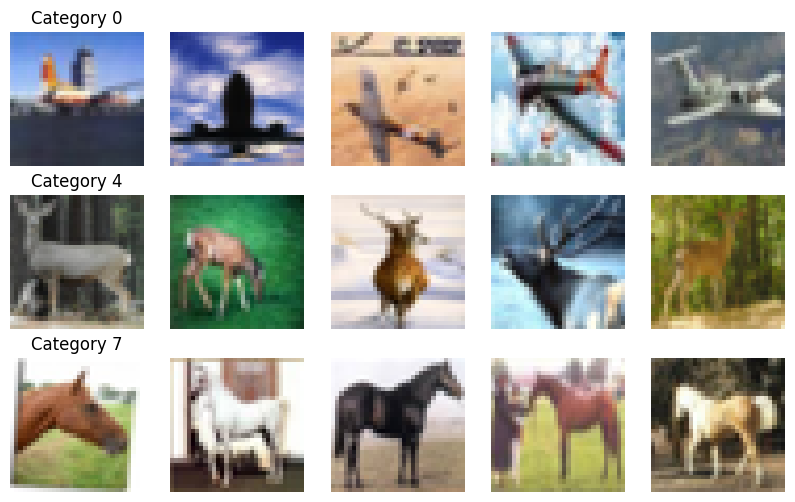

In [22]:
def plot_sample_images(data, labels, categories, num_samples=5):
    fig, axs = plt.subplots(len(categories), num_samples, figsize=(num_samples * 2, len(categories) * 2))

    for idx, category in enumerate(categories):
        indices = np.where(labels == category)[0]
        random_indices = np.random.choice(indices, num_samples, replace=False)

        for j, image_index in enumerate(random_indices):
            ax = axs[idx, j] if len(categories) > 1 else axs[j]
            ax.imshow(data[image_index])
            ax.axis('off')
            if j == 0:
                ax.set_title(f"Category {category}")
    plt.show()

plot_sample_images(X_train_filtered, y_train_filtered.flatten(), categories)

extract features

In [23]:
def extract_multiscale_features(image):
    scales = [1, 2, 4]  # Example scales
    features = []

    for scale in scales:
        # Apply Gaussian filter
        gaussian = cv2.GaussianBlur(image, (0, 0), scale)
        features.append(gaussian)

        # Apply edge detection
        edges = feature.canny(color.rgb2gray(image), sigma=scale)
        edges = edges[:, :, np.newaxis]  # Convert to 3D
        edges = np.repeat(edges, 3, axis=2)  # Repeat to match the RGB image
        features.append(edges)

    # Stack features along the depth dimension
    features = np.concatenate(features, axis=2)
    return features

use spectral clustering

In [24]:
def apply_spectral_clustering(image, n_clusters=4):
    # Reshape image to (num_pixels, num_features)
    h, w, d = image.shape
    flat_image = image.reshape(-1, d)

    # Apply Spectral Clustering
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', assign_labels='kmeans', random_state=42)
    labels = spectral.fit_predict(flat_image)

    # Reshape labels back to the original image shape
    segmented_image = labels.reshape(h, w)
    return segmented_image


deply images after multi feature extracted stpectral clustering

In [26]:
def deploy(original_images, segmented_images, categories, num_samples=5):
    fig, axs = plt.subplots(len(categories), num_samples * 2, figsize=(num_samples * 4, len(categories) * 2))

    for idx, category in enumerate(categories):
        for j in range(num_samples):
            original_ax = axs[idx, j * 2] if len(categories) > 1 else axs[j * 2]
            segmented_ax = axs[idx, j * 2 + 1] if len(categories) > 1 else axs[j * 2 + 1]

            original_ax.imshow(original_images[category][j])
            original_ax.set_title("Original Image")
            original_ax.axis('off')

            segmented_ax.imshow(segmented_images[category][j], cmap='viridis')
            segmented_ax.set_title("Segmented Image")
            segmented_ax.axis('off')

    plt.tight_layout()
    plt.show()

deply the images

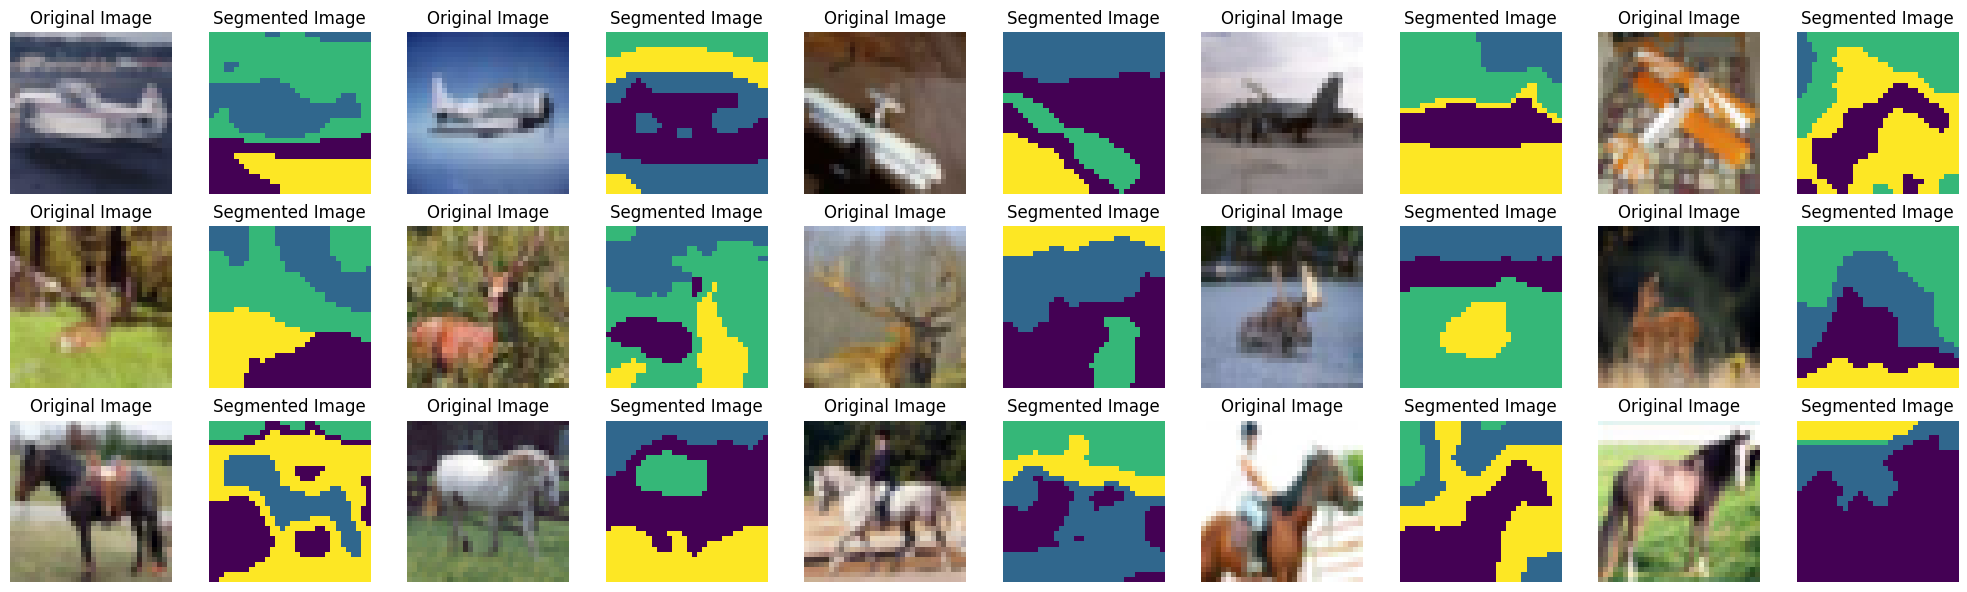

In [27]:
original_images = {category: [] for category in categories}
segmented_images = {category: [] for category in categories}

for category in categories:
    for image_index in sampled_indices[category]:
        sample_image = X_train_filtered[image_index]
        features = extract_multiscale_features(sample_image)
        segmented_image = apply_spectral_clustering(features)
        segmented_image_resized = cv2.resize(segmented_image, (sample_image.shape[1], sample_image.shape[0]), interpolation=cv2.INTER_NEAREST)

        original_images[category].append(sample_image)
        segmented_images[category].append(segmented_image_resized)

deploy(original_images, segmented_images, categories)